# Predict car accident along the selected route

## Project description

The task is to create an accident prediction system for a carsharing company. 

After the driver has booked a car, got in the car and chosen a route, the system should assess the level of risk. If the risk level is high, the driver will see a warning and recommendations along the route.

The idea of creating such a system is under discussion. The purpose of the project: to understand whether it is possible to predict an accident based on historical data from one of the regions. 

Customer's requirements:
- _PARTY_TYPE_ (type of accident participant) is car;
- all _COLLISION_DAMAGE_ except scratch;
- 2012 year

## Project plan:

1. Statistical analysis of accident factors.
2. Select the necessary factors for analysis and building the model. Prepare data based on customer's requirements.
2. Create different learning models.
3. Analyze the results, compare quality metric, time of work, features importance.
4. Conclude is it possible to create an accident risk assessment system.

## Data description
__Table `collisions` (information about accidents) columns__:
- _CASE_ID_ — identification number in the database
- _COLLISION_DATE_ — date of the accident
- _COLLISION_TIME_ — time of the accident
- _INTERSECTION_ — is the place of the accident an intersection
- _WEATHER_1_ — weather
- _COLLISION_DAMAGE_ — degree of damage
- _PRIMARY_COLL_FACTOR_ — the main factor of the accident
- _ROAD_SURFACE_ — road condition
- _LIGHTING_ — street lighting
- _COUNTY_CITY_LOCATION_ — The number of geographical areas where the accident occurred
- _COUNTY_LOCATION_ - names of geographical areas where the accident occurred
- _DIRECTION_ — direction of movement
- _DISTANCE_ — distance from the main road (meters)
- _LOCATION_TYPE_ — type of road
- _PARTY_COUNT_ — number of participants in the accident
- _PCF_VIOLATION_CATEGORY_ — violation category
- _TYPE_OF_COLLISION_ - type of collision
- _MOTOR_VEHICLE_INVOLVED_WITH_ — other participants in the accident
- _ROAD_CONDITION_1_ — road surface condition
- _CONTROL_CONDITION_1_ — control device

__Table `Parties` (description of the participants of the accidents) columns__:
- _CASE_ID_ — identification number in the database
- _PARTY_NUMBER_ — number of the accident participant
- _PARTY_TYPE_ — type of accident participant
- _AT_FAULT_ — is participant guilty
- _INSURANCE_PREMIUM_ — insurance amount (thousand $)
- _PARTY_DRUG_PHYSICAL_ — participant's condition: physical or was taking medication
- _PARTY_SOBRIETY_ — participant's sobriety
- _CELLPHONE_IN_USE_ — is phone in the car (or ability to talk on speakerphone)

__Table `Vehicles` (description of the car) columns__:
- _ID_ — index of the current table
- _CASE_ID_ — identification number in the database
- _VEHICLE_TYPE_ — vehicle body type
- _VEHICLE_TRANSMISSION_ — transmission type
- _VEHICLE_AGE_ — age of the car (years)


__Target feature__: _AT_FAULT_ from Table `Parties`

## Read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
db_config = {
'user': 'user',
'pwd': 'password',
'host': 'host',
'port': 0,
'db': 'db_name'
}
 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [3]:
def upload_table(table_name):
    query = f'''
    SELECT *
    FROM {table_name}
    LIMIT 10
    '''
    return pd.read_sql_query(query, con=engine)

collisions = upload_table("collisions")
parties = upload_table("Parties")
vehicles = upload_table("Vehicles")
case_ids = upload_table("case_ids")

dfs = [collisions, parties, vehicles, case_ids]

for df in dfs:
    display(df.head())

case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         sideswipe   
1   vehicle code violation         improper passing        hit object   
2   vehicle code violation         improper turning         broadside   
3   vehicle code violation  automobile right of way         broadside   
4   vehicle code violation                 speeding          rear end   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          wet           normal   
1                fixed object          dry           normal   
2         other motor vehicle          dry           normal   
3         other motor vehicle          dry           normal   
4         other motor vehicle          dry             None   

                  lighting control_device collision_date collision_time  
0                 daylight           none     2009-01-22       07:25:00  
1  dark with street lights    functioning     2009-01-03       02:26:00  
2  dark with street lights    functioning     2009-01-11       03:32:00  
3                 daylight    functioning     2009-01-11       10:35:00  
4  dark with street lights    functioning     2009-01-02       22:43:00

id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None               0.0  
1  had not been drinking                None               0.0  
2  had not been drinking                None               0.0  
3  had not been drinking                None               0.0  
4         not applicable      not applicable               0.0

id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5

case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021
3  3899441    2021
4  3899442    2021

## Initial analysis of tables

Let's check if the number of tables corresponds to the task condition:

In [4]:
query = '''
SELECT *
FROM information_schema.tables
WHERE table_schema = 'public'
'''
pd.read_sql_query(query, con=engine)

table_catalog table_schema  table_name  table_type  \
0  data-science-vehicle-db       public    case_ids  BASE TABLE   
1  data-science-vehicle-db       public  collisions  BASE TABLE   
2  data-science-vehicle-db       public     parties  BASE TABLE   
3  data-science-vehicle-db       public    vehicles  BASE TABLE   

  self_referencing_column_name reference_generation user_defined_type_catalog  \
0                         None                 None                      None   
1                         None                 None                      None   
2                         None                 None                      None   
3                         None                 None                      None   

  user_defined_type_schema user_defined_type_name is_insertable_into is_typed  \
0                     None                   None                YES       NO   
1                     None                   None                YES       NO   
2                     None                   None                YES       NO   
3                     None                   None                YES       NO   

  commit_action  
0          None  
1          None  
2          None  
3          None

The number of tables is correct. There is a common `case_id` key for linking tables.

## Statistical analysis of accident factors

In [9]:
def drow_plot(indexes, data, title, xlabel, ylabel):
    plt.figure(figsize = (15, 5))
    plt.bar(indexes, data, width = 0.4)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

Let's find out which months have the most accidents. To begin with, let's check that data is available for all months for all years.

In [3]:
query = '''
SELECT EXTRACT(YEAR FROM collision_date)::int AS year,
       EXTRACT(MONTH FROM collision_date)::int AS month,
       COUNT(*) AS count
FROM collisions
GROUP BY year, month
ORDER BY year, month
'''
df = pd.read_sql_query(query, con=engine)
df

year  month  count
0   2009      1  35062
1   2009      2  34480
2   2009      3  36648
3   2009      4  35239
4   2009      5  36916
5   2009      6  34202
6   2009      7  35161
7   2009      8  34508
8   2009      9  35555
9   2009     10  37835
10  2009     11  34562
11  2009     12  36060
12  2010      1  32892
13  2010      2  31918
14  2010      3  35803
15  2010      4  34416
16  2010      5  34862
17  2010      6  33367
18  2010      7  33645
19  2010      8  34620
20  2010      9  34957
21  2010     10  37480
22  2010     11  35460
23  2010     12  37070
24  2011      1  31926
25  2011      2  31975
26  2011      3  34585
27  2011      4  31377
28  2011      5  33370
29  2011      6  31962
30  2011      7  33029
31  2011      8  34339
32  2011      9  34137
33  2011     10  36618
34  2011     11  34495
35  2011     12  34615
36  2012      1  32020
37  2012      2  30377
38  2012      3  32498
39  2012      4  29143
40  2012      5  25168
41  2012      6   3062
42  2012      7    390
43  2012      8    622
44  2012      9    510
45  2012     10    304
46  2012     11    253
47  2012     12    200
48  2013      1    144
49  2013      2    108
50  2013      3     46
51  2013      4      5
52  2013      6      1
53  2013      7      1
54  2020      3      1
55  2020      7      1

There are no data for some months for 2013 and 2020 years. There is very little data for some months of 2012 year. This is also low-quality data. Take only the data for 2009-2011 years for analysis by month.

In [7]:
query = '''
SELECT TO_CHAR(collision_date, 'month') AS month,
       COUNT(*) AS count
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date)::int BETWEEN 2009 AND 2011
GROUP BY month
ORDER BY count DESC
'''
df = pd.read_sql_query(query, con=engine)
df

month   count
0   october    111933
1   december   107745
2   march      107036
3   may        105148
4   september  104649
5   november   104517
6   august     103467
7   july       101835
8   april      101032
9   january     99880
10  june        99531
11  february    98373

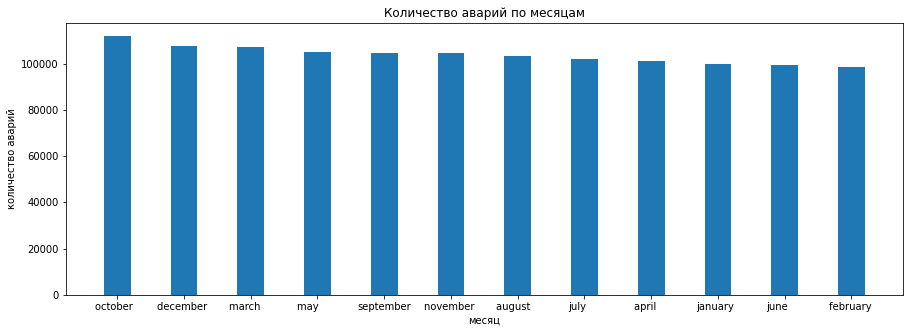

In [11]:
drow_plot(df['month'], df['count'], 'Количество аварий по месяцам', 'месяц', 'количество аварий')

Accidents are about the same number every month. The difference is insignificant.

### Examples of analytical tasks

Examples of analytical tasks. Next, solve 2 of them.

1. Investigate the relationship of the participant's sobriety with the month of accident.
2. At what hours of day was accident for accidents where the initiator felt sleepy.
3. To investigate the dependence of the frequency of accidents on the time of day.
4. Count the number of accidents for old, medium and new cars (create a column of age category with 3 values)
5. Investigate the dependence of the frequency of accidents on the weather.
6. Does an accident at an intersection mean that there are several participants in the accident?

#### Solving problem 1
Investigate the relationship of the participant's sobriety with the month of accident.

Select drivers who were had been drinking and were guilty of the accident. Calculate how many accidents were with that drivers in different months.

month  count
0   october    10655
1   december   10487
2   may        10485
3   july       10459
4   august     10044
5   november   10031
6   march       9926
7   january     9784
8   april       9711
9   february    9523
10  june        9500
11  september   9305

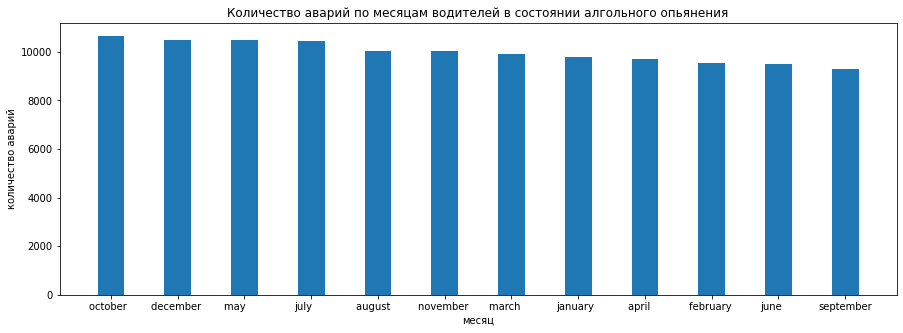

In [12]:
query = '''
SELECT TO_CHAR(collision_date, 'month') AS month,
       COUNT(*) AS count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.party_sobriety LIKE 'had been drinking%%'
AND EXTRACT(YEAR FROM collision_date)::int BETWEEN 2009 AND 2011
AND p.at_fault = 1
GROUP BY month
ORDER BY count DESC
'''
drunk_cases = pd.read_sql_query(query, con=engine)
display(drunk_cases)
drow_plot(drunk_cases['month'], drunk_cases['count'], 'Количество аварий по месяцам водителей в состоянии алгольного опьянения', 'месяц', 'количество аварий')

There were more accidents under the influence of alcohol in May, July, and August.

#### Solving problem 2
At what hours of day was accident for accidents where the initiator felt sleepy.

Select the participants who felt sleepy and were guilty of the accident. Than group count of accidents by hours.

hour  count
0    0.0    482
1    1.0    592
2    2.0    718
3    3.0    727
4    4.0    768
5    5.0    824
6    6.0    890
7    7.0    820
8    8.0    652
9    9.0    344
10  10.0    279
11  11.0    287
12  12.0    346
13  13.0    379
14  14.0    513
15  15.0    609
16  16.0    583
17  17.0    516
18  18.0    305
19  19.0    220
20  20.0    201
21  21.0    229
22  22.0    318
23  23.0    440

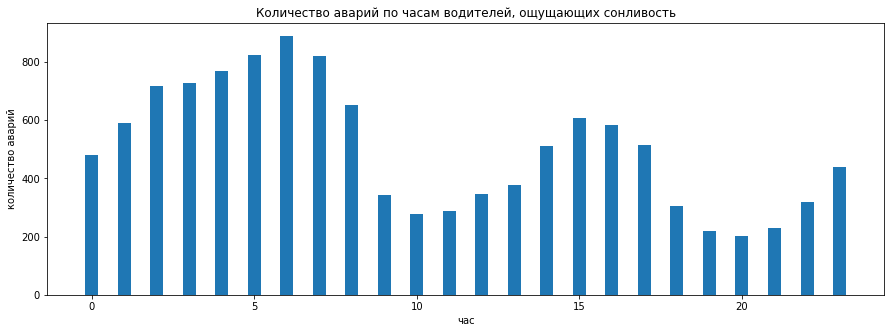

In [9]:
query = '''
SELECT EXTRACT(HOUR FROM collision_time) AS hour,
       COUNT(*) AS count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.party_drug_physical = 'sleepy/fatigued'
AND p.at_fault = 1
AND c.collision_time IS NOT NULL
GROUP BY hour
ORDER BY hour
'''
sleep_hours = pd.read_sql_query(query, con=engine)
display(sleep_hours)
drow_plot(sleep_hours['hour'], sleep_hours['count'], 'Количество аварий по часам водителей, ощущающих сонливость', 'час', 'количество аварий')

It looks logical. There are more accidents with sleepy drivers at night and in the morning. The peak is at 5-7 am.

## Model for assessing driving risk

### Preparing a dataset

Select the necessary factors for analysis and building the model:

Select from `collisions` table:

- `county_city_location`. There may be areas with high traffic, areas with bars or criminal areas, which may affect the number of accidents;
- `direction`. In combination with other signs, such as the area and time, it may affect the accident. For example, in some area, at 6 p.m., people drive north from work, so create traffic and accidents;
- `intersection`. Intersections are places of increased danger;
- `weather_1`. Weather conditions affect accidents. For example, fog creates poor visibility;
- `location_type`. Probably there are different types and frequency of accidents on different sections of the road (highway/intersection);
- `collision_damage`. To identify the sections of the route where the most serious accidents occur;
- `party_count`. Not so obvious, but add it. Maybe there are intersections or other sections of the road where several cars regularly crash;
- `pcf_violation_category`. It may indicate tat there are more violation categories in some areas (like falling asleep in one area, speeding in another)
- `motor_vehicle_involved_with`. It can also talk about the nature of an accident on different routes. For example, there is a risk of an accident with animals in some area;
- `road_surface`. Definitely affects. For example, more accidents happen on icy road;
- `road_condition_1`. Definitely affects. For example, there are more accidents in areas with road damage;
- `lighting`. The level of illumination definitely affects. Low visibility means more dangerous road;
- `collision_date`. As we have already found out, there are more accidents in some months. Extract and use only the month from the date;
- `collision_time`. As we have already found out, there are more accidents at some hours of the day. Extract and use only an hour of time. Combine them into 2-hour intervals to reduce amount of values;
- `control_device`. There is a version that control systems can cause accidents and that they are not recommended to be used in the rain, etc.;

Not select from `collisions` table:

- `county_location`. Contain extra information as in `county_city_location` column;
- `distance`. Distance the main road does not seem to be a sign that affects an accident;
- `primary_collision_factor`. Contain extra information as `pcf_violation_category` column;
-`type_of_collision`. It doesn't seem to give more information than `pcf_violation_category`. At the same time, even if there can be different type of collisions in the accidents on the same place and type of accident;

Select from `parties` table:

- `at_fault`. Target attribute;
- `party_sobriety`. The sobriety of the participant definitely affects the risk of an accident;
- `party_drug_physical`. Physical condition definitely affects the risk of an accident;
- `cellphone_in_use`. If I understand correctly, this column contains information about was the phone used. Using a phone while driving affects attentiveness and the risk of getting into an accident;

Not select from `parties` table:

- `party_number`;
- `party_type`. Use this column just to select the data where the car is involved in the incident;

Select from `vehicles` table:

- `vehicle_type`. The body type can affect the difficulty of driving. For example some cars have large blind spots;
- `vehicle_transmission`. It may affect the speed of the driver's response. There are versions that for more dangerous roads, for example, serpentine roads, a manual transmission is better suited;
- `vehicle_age`. The age of the car may affect the risk of an accident. Older cars often mean more defects.

Prepare data based on customer's requirements:
- party_type is car;
- all collision_damage except scratch;
- 2012 year

In [21]:
query = '''
SELECT c.county_city_location,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.collision_damage,
       c.party_count,
       c.pcf_violation_category,
       c.motor_vehicle_involved_with,
       c.road_surface,
       c.road_condition_1,
       c.lighting,
       EXTRACT(HOUR FROM c.collision_time) AS hour,
       EXTRACT(MONTH FROM c.collision_date) AS month,
       c.control_device,
       p.at_fault,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age
FROM vehicles v 
JOIN parties p ON v.case_id = p.case_id AND v.party_number = p.party_number
JOIN collisions c ON v.case_id = c.case_id
WHERE p.party_type = 'car'
    AND c.collision_damage != 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012
'''
df = pd.read_sql_query(query, con=engine)
df.head()

county_city_location direction  intersection weather_1 location_type  \
0                 1955      east           0.0     clear          ramp   
1                 3600      east           0.0     clear       highway   
2                 4006     south           0.0     clear          None   
3                 3344     north           0.0     clear       highway   
4                 2000     south           0.0     clear       highway   

  collision_damage  party_count pcf_violation_category  \
0     small damage            2     unsafe lane change   
1    middle damage            1               speeding   
2    middle damage            3               speeding   
3     small damage            2               speeding   
4    middle damage            1       improper turning   

  motor_vehicle_involved_with road_surface  ...  hour month  control_device  \
0         other motor vehicle          dry  ...  11.0   1.0     functioning   
1                fixed object          dry  ...  19.0   1.0     functioning   
2         other motor vehicle          dry  ...   9.0   2.0     functioning   
3         other motor vehicle          dry  ...  17.0   1.0            none   
4               non-collision          dry  ...  22.0   1.0            none   

   at_fault         party_sobriety  party_drug_physical cellphone_in_use  \
0         1  had not been drinking                 None              0.0   
1         1  had not been drinking                 None              0.0   
2         0  had not been drinking                 None              0.0   
3         1  had not been drinking                 None              0.0   
4         1  had not been drinking                 None              0.0   

  vehicle_type  vehicle_transmission vehicle_age  
0        sedan                  auto        10.0  
1        coupe                manual        11.0  
2        coupe                  auto        10.0  
3        sedan                manual         4.0  
4        coupe                manual         4.0  

[5 rows x 22 columns]

Check the data for missing values, outliers, duplicates:

In [5]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are missing values, duplicates and outliers in the `vehicle_age` column (2 records with an age of 161 years). Remove missing values and objects with too much age.

Some columns have value _other_. I don't replace missing values with  _other_, because  _other_ probably means rare values but not missing values. So I replace missing values with _unknown_ in the categorical columns. 

Missing values in `vehicle_age`, `collision_time` will be replaced with median values, there are not so many missing values in these columns.

In [22]:
df = df[df['vehicle_age'] < 20]

columnts_to_fillna_unknown = ['direction', 'location_type', 'intersection', 'weather_1', 'pcf_violation_category', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'vehicle_transmission']
columnts_to_fillna_median = ['hour', 'vehicle_age']

df[columnts_to_fillna_unknown] = df[columnts_to_fillna_unknown].fillna(value='unknown')
df[columnts_to_fillna_median] = df[columnts_to_fillna_median].fillna(df[columnts_to_fillna_median].median())

for col in columnts_to_fillna_unknown:
    df[col] = df[col].astype(str)
    
df = df.drop_duplicates()

Combine the hours into 2-hour intervals to reduce amount of columns after encoding. And fix the data types.

In [23]:
df['hour'] = df['hour'].replace({0: '0-1', 1: '0-1', 2: '2-3', 3: '2-3', 4: '4-5', 5: '4-5', 6: '6-7', 7: '6-7', 8: '8-9',
                                 9: '8-9', 10: '10-11', 11: '10-11', 12: '12-13', 13: '12-13', 14: '14-15', 15: '14-15', 16: '16-17',
                                 17: '16-17', 18: '18-19', 19: '18-19', 20: '20-21', 21: '20-21', 22: '22-23', 23: '22-23'
                                })

df[['vehicle_age']] = df[['vehicle_age']].astype('int64')
df['month'] = df['month'].astype(str)

Split the data on training, validation, and test samples in a ratio of 60:20:20.

In [24]:
def split_set(df, target_feature):
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(
        df.drop(target_feature, axis=1), df[target_feature], test_size=0.4, random_state=12345)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

Functions for model analysis:

In [25]:
def draw_confusion_matrix(target, predictions):
    matrix = confusion_matrix(target, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    
def print_metrics(target, predictions):
    print('f1:', f1_score(target, predictions))
    print('precision:', precision_score(target, predictions))
    print('recall:', recall_score(target, predictions))

Use Ordinal Encoding to encode categorical features. Scale numerical features.

In [26]:
cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = ['party_count', 'vehicle_age']

col_trans_oe = ColumnTransformer(transformers=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

features_train, target_train, features_valid, target_valid, features_test, target_test = split_set(df, 'at_fault')

Choosing a metric:

It is more important to minimize false negative predictions in our task (when the model predicts that there will be no accident, but it happens). But false positive predictions cannot be ignored. If the driver is too often given unnecessary route recommendations that complicate it, they will not want to use such a service. So use the f1 metric that takes their harmonic mean.

### DecisionTreeClassifier

In [27]:
parametrs_dt = { 
    'model__max_depth': range (5,18),
    'model__min_samples_leaf': range (5,8),
    'model__criterion': ['gini','entropy']
}

pipeline_dt = Pipeline(steps=[
    ('col_trans', col_trans_oe),
    ('model', DecisionTreeClassifier(random_state=12345))
])

grid_pipeline_dt = GridSearchCV(pipeline_dt, parametrs_dt)
grid_pipeline_dt.fit(features_train, target_train)
predictions_dt = grid_pipeline_dt.predict(features_valid)
f1_dt = f1_score(target_valid, predictions_dt)
best_dt = grid_pipeline_dt.best_estimator_

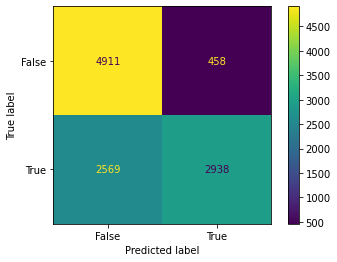

f1: 0.6600022464337864
precision: 0.8651354534746761
recall: 0.5335028145996005


In [28]:
draw_confusion_matrix(target_valid, predictions_dt)
print_metrics(target_valid, predictions_dt)

### CatBoostClassifier

In [29]:
params_cb = {'depth': [6,8,10],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations' : [30, 50, 100]
            }

grid_cb = GridSearchCV(estimator=CatBoostClassifier(loss_function='CrossEntropy', cat_features=cat_cols, silent=True, random_state=12345), param_grid = params_cb)
grid_cb.fit(features_train, target_train)
best_cb = grid_cb.best_estimator_
predictions_cb = grid_cb.predict(features_valid)
f1_cb = f1_score(target_valid, predictions_cb)
best_cb
print('f1_cb:', f1_cb)
print('best_cb:', best_cb)

f1_cb: 0.6890178379540082
best_cb: <catboost.core.CatBoostClassifier object at 0x7f395fd174c0>


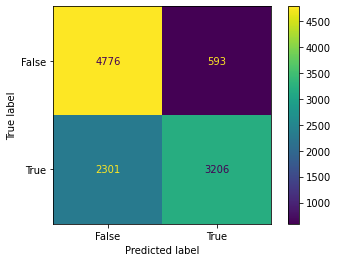

f1: 0.6890178379540082
precision: 0.8439062911292445
recall: 0.5821681496277465


In [30]:
draw_confusion_matrix(target_valid, predictions_cb)
print_metrics(target_valid, predictions_cb)

### RandomForestClassifier

In [31]:
params_rf = {'model__max_depth': range (5,20),
             'model__n_estimators': range(1, 100, 10)}

pipeline_rf = Pipeline(steps=[
    ('col_trans', col_trans_oe),
    ('model', RandomForestClassifier(random_state=12345))
])

grid_pipeline_rf = GridSearchCV(pipeline_rf, params_rf, n_jobs=-1)
grid_pipeline_rf.fit(features_train, target_train)
best_rf = grid_pipeline_rf.best_estimator_

predictions_rf = grid_pipeline_rf.predict(features_valid)
f1_rf = f1_score(target_valid, predictions_rf)

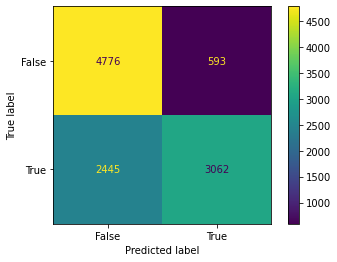

f1: 0.6684130102597686
precision: 0.8377564979480164
recall: 0.5560196114036681


In [32]:
draw_confusion_matrix(target_valid, predictions_rf)
print_metrics(target_valid, predictions_rf)

Comparison of model metrics:

In [33]:
data = {
    "DecisionTreeClassifier": [f1_dt],
    "RandomForestClassifier": [f1_rf],
    "CatBoostClassifier": [f1_cb]
}

models_analys = pd.DataFrame(data=data, index=["F1"])
display(models_analys)

DecisionTreeClassifier  RandomForestClassifier  CatBoostClassifier
F1                0.660002                0.668413            0.689018

The best f1 metric has CatBoostClassifier model, check it on a test data.

In [34]:
predictions_cb_test = best_cb.predict(features_test)
print_metrics(target_test, predictions_cb_test)

f1: 0.6904736217499191
precision: 0.8409986859395532
recall: 0.5856515373352855


In the test sample, f1-measure = 0.69.

## Analysis of features importance

Build a plot of features importance for every model:

DecisionTreeClassifier


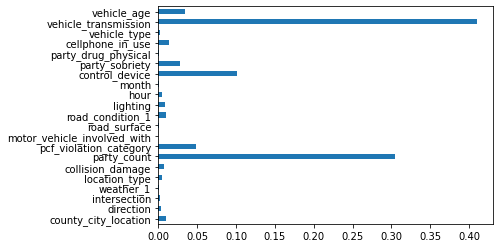

RandomForestClassifier


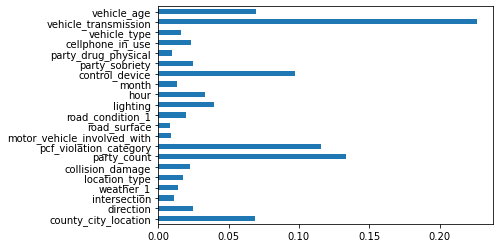

CatBoostClassifier


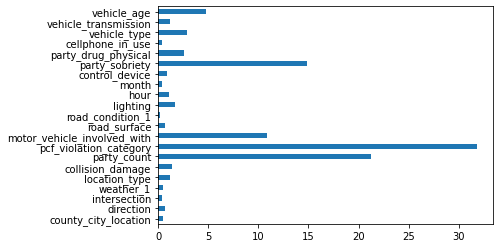

In [35]:
print('DecisionTreeClassifier')
pd.Series(best_dt._final_estimator.feature_importances_, index=features_train.columns).plot(kind='barh')
plt.show()

print('RandomForestClassifier')
pd.Series(best_rf._final_estimator.feature_importances_, index=features_train.columns).plot(kind='barh')
plt.show()

print('CatBoostClassifier')
pd.Series(best_cb.feature_importances_, index=features_train.columns).plot(kind='barh')
plt.show()

The most important features for model DecisionTreeClassifier:
- `vehicle_transmission` (transmission type)
- `party_count` (number of participants in the accident)

The most important features for model RandomForestClassifier:
- `vehicle_transmission` (transmission type)
- `party_count` (number of participants in the accident)

The most important features for model CatBoostClassifier:
- `pcf_violation_category` (violation category)
- `party_count` (number of participants in the accident)

Explore the `pcf_violation_category` feature. Plot the dependence of the feature and the target value.

<AxesSubplot:xlabel='pcf_violation_category'>

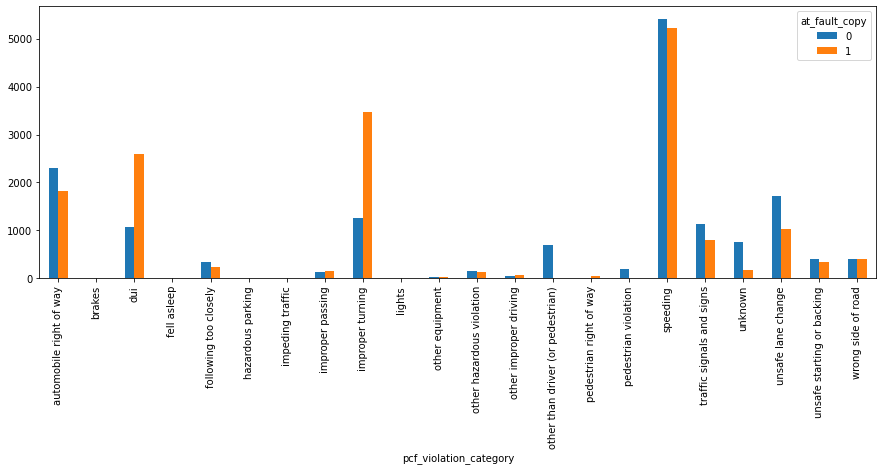

In [36]:
df_pivot = features_train.copy()
df_pivot['at_fault'] = target_train
df_pivot['at_fault_copy'] = target_train
pivot = pd.pivot_table(df_pivot, values='at_fault', index=['pcf_violation_category'], columns=['at_fault_copy'], aggfunc="count")

pivot.plot(kind='bar', figsize = (15, 5))

It can be seen from the plot that there are more values of the positive class when `pcf_violation_category` = `improperly passing` (wrong movement), `dui` (driving under the influence of alcohol or drugs) and `pedestrian right of way`.

Adding an alcohol intoxication sensor to the car could reduce the number of accidents.

## Conclusion

The f1 metric of the models between 0.66-0.69. The best model is CatBoostClassifier model with f1 = 0.69 in the test sample.

The current model predicts slightly better than the basic one. Perhaps it is possible to create good accident forecasting system if add features: the speed of the car at the time of the accident, age, experience of the driver.